In [1]:
import GPy, GPyOpt
import numpy as np
import math, time

In [2]:
def ReadDataExercise3(filepath):
    data = []
    with open(filepath) as f:
        f.readline()
        for line in f:
            line = line.strip().split(',')
            data.append(line[-2:])        
    return data

In [3]:
filepath = 'ex3_data.csv'
data = ReadDataExercise3(filepath)
print(len(data))

9051


In [4]:
def OneHotEncodePeptide(sequence):
    num_aa = len(sequence)
    AminoAcids = [
        "G", "A", "S", "P", "V",
        "T", "C", "I", "L", "N",
        "D", "K", "Q", "E", "M",
        "H", "F", "R", "Y", "W"
    ]
    AminoAcids = sorted(AminoAcids)
    AA_Dictionary = {key:i for i,key in enumerate(AminoAcids)}
    
    one_hot_seq = np.zeros((num_aa,len(AminoAcids)), dtype = float)
    for i, letter in enumerate(sequence):
        one_hot_seq[i,AA_Dictionary[letter]] = 1
    return one_hot_seq.flatten()
    

In [5]:
oh_data = [OneHotEncodePeptide(str(x[0])) for x in data]
processed_data = [[a, *b] for a,b in zip(oh_data, data)] # one-hot encoded, aa_sequence, label
x = np.array([ele[0] for ele in processed_data])
x_seq = [ele[1] for ele in processed_data]
y = np.array([float(ele[2]) for ele in processed_data])  
print('Feature Shape:', x.shape, '\nLabel Shape:', y.shape)

Feature Shape: (9051, 180) 
Label Shape: (9051,)


Gaussian Process

In [9]:
def SplitData(x, y, split_percent, seed):
    """
    Split x and y into a training and testing set.
    Input:
    x (np.ndarray): Features. (N x m)
    y (np.ndarray): Labels. (N)
    split_percent (float): Percent of data to use for initial training set (labeled).
    seed (float): seed for randomizer.

    Output:
    x_lab, y_lab, x_unlab, y_unlab (np.ndarray): The split datasets.
    """
    # Split data into test and train.
    rng = np.random.default_rng(seed)
    shuffled_idx = np.arange(x.shape[0])
    rng.shuffle(shuffled_idx)
    shuffled_x = x[shuffled_idx]
    shuffled_y = y[shuffled_idx]

    n = len(y)
    x_lab = shuffled_x[:int(n*split_percent)]
    y_lab = shuffled_y[:int(n*split_percent)]
    x_unlab = shuffled_x[int(n*split_percent):]
    y_unlab = shuffled_y[int(n*split_percent):]
    return x_lab, y_lab, x_unlab, y_unlab

In [6]:
# We're going to use the GP in the same way multiple times, so let's create a function
def GP_analysis(X, Y, X_grid):
    # Use GP regression to fit the data
    k = GPy.kern.RBF(X.shape[1])
    m = GPy.models.SparseGPRegression(X, Y, k)

    m.optimize('bfgs', max_iters=10)
    
    # Predict the mean and covariance of the GP fit over the grid
    mean, variance = m.predict(X_grid, full_cov=False)
    # variance = np.diag(Cov)
    return mean, variance, m

In [7]:
def GaussianProcess(x, y, split_percent, seed):
    """ 
    Chooses next sample using gaussian process. Logs samples that have a label of 9.0
    Input:
    x (np.ndarray): Features. (N x m)
    y (np.ndarray): Labels. (N)
    split_percent (float): Percent of data to use for initial training set (labeled).
    seed (float): seed for randomizer.

    Output:
    count (int): Number of samples with 9.0 label sampled.
    percentages (list): Percent of samples with 9.0 labeled at each time step.
    samples (np.ndarray): The samples with 9.0 labels.
    """
    if y.ndim == 1:
        y = y[:, np.newaxis]
    # Split data into test and train.
    x_lab, y_lab, x_unlab, y_unlab = SplitData(x,y,split_percent,seed)

    Dsize = len(x)
    BO_lambda = .1
    BO_number_of_iterations = 1

    count = 0
    percentages = []
    samples = []
    for i in range(0, 200):
        print(f'{i}', end = '\r')

        # Use GP regression to fit the data
        mean, variance, m = GP_analysis(x_lab, y_lab, x_unlab)

        # Compute UCB
        BO_beta = 2 * math.log(Dsize * math.pow(BO_number_of_iterations,2) * math.pow(np.pi,2) / (6 * BO_lambda) )
        alpha_full = mean + math.sqrt(BO_beta) * variance

        # Find the next sample
        next_sample_index = np.argmax(alpha_full)

        # Logging metrics.
        if y_unlab[next_sample_index] == 9.0:
            count += 1
            samples.append(x_unlab[next_sample_index])
        percentages.append(count/(i + 1)*100)

        # Remove chosen sample from unlabled and add to labled
        x_lab = np.vstack((x_lab, x_unlab[next_sample_index]))
        y_lab = np.vstack((y_lab, y_unlab[next_sample_index]))
        x_unlab = np.delete(x_unlab, next_sample_index, axis = 0)
        y_unlab = np.delete(y_unlab, next_sample_index)

    samples, percentages = np.array(samples), np.array(percentages)
    return count, percentages, samples


In [8]:
save = True
count, percentages, samples = GaussianProcess(x, y, 0.8, 2024)

if save:
    np.save('results/GP_count.npy', count)
    np.save('results/GP_percents.npy', percentages)
    np.save('results/GP_samples.npy', samples)

Random Process

In [12]:
def RandomProcess(x, y, split_percent, seed):
    """ 
    Chooses next sample randomly. Logs samples that have a label of 9.0
    Input:
    x (np.ndarray): Features. (N x m)
    y (np.ndarray): Labels. (N)
    split_percent (float): Percent of data to use for initial training set (labeled).
    seed (float): seed for randomizer.

    Output:
    count (int): Number of samples with 9.0 label sampled.
    percentages (list): Percent of samples with 9.0 labeled at each time step.
    samples (np.ndarray): The samples with 9.0 labels.
    """
    if y.ndim == 1:
        y = y[:, np.newaxis]
    rng = np.random.default_rng(seed)
    x_lab, y_lab, x_unlab, y_unlab = SplitData(x,y,split_percent,seed)

    count = 0
    percentages = []
    samples = []
    for i in range(0, 200):
        print(f'{i}', end = '\r')
        # Find the next sample
        next_sample_index = rng.integers(0, x_unlab.shape[0], 1)

        # Logging metrics.
        if y_unlab[next_sample_index] == 9.0:
            count += 1
            samples.append(x_unlab[next_sample_index])
        percentages.append(count/(i + 1)*100)

        # Remove chosen sample from unlabled and add to labled
        x_lab = np.vstack((x_lab, x_unlab[next_sample_index]))
        y_lab = np.vstack((y_lab, y_unlab[next_sample_index]))
        x_unlab = np.delete(x_unlab, next_sample_index, axis = 0)
        y_unlab = np.delete(y_unlab, next_sample_index)

    samples, percentages = np.array(samples), np.array(percentages)
    return count, percentages, samples

In [13]:
save = True
count, percentages, samples = RandomProcess(x, y, 0.8, 2024)

if save:
    np.save('results/RP_count.npy', count)
    np.save('results/RP_percents.npy', percentages)
    np.save('results/RP_samples.npy', samples)

Visualization

In [17]:
import matplotlib.pyplot as plt
import numpy as np

In [18]:
def ReadDataExercise3(filepath):
    data = []
    with open(filepath) as f:
        f.readline()
        for line in f:
            line = line.strip().split(',')
            data.append(line[-2:])        
    return data

filepath = 'ex3_data.csv'
data = ReadDataExercise3(filepath)
n = len(data)

Text(0.5, 1.0, 'Percent of new samples with 9.0 IC50')

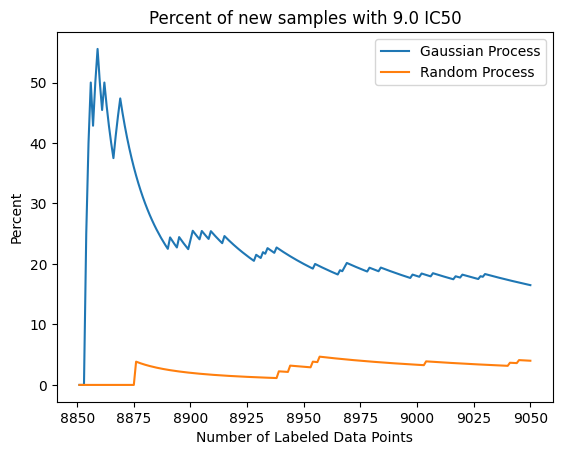

In [21]:
paths = ['results/GP_percents.npy', 'results/RP_percents.npy']
label = ['Gaussian Process', 'Random Process']

fig, ax = plt.subplots(1)

for i,path in enumerate(paths):
    data = np.load(path)
    x = np.arange(n-len(data), n)
    handle, = ax.plot(x, data, label = label[i])
    ax.legend()

ax.set_ylabel('Percent')
ax.set_xlabel('Number of Labeled Data Points')
ax.set_title('Percent of new samples with 9.0 IC50')


Seqlogo

In [25]:
import seqlogo

In [26]:
def ReverseOneHotEncodePeptide(sequence):
    AminoAcids = [
        "G", "A", "S", "P", "V",
        "T", "C", "I", "L", "N",
        "D", "K", "Q", "E", "M",
        "H", "F", "R", "Y", "W"
    ]
    AminoAcids = sorted(AminoAcids)
    AA_Dictionary = {i:key for i,key in enumerate(AminoAcids)}
    
    sequence = sequence.reshape(-1, 20)
    decoded = ''
    for row in sequence:
        decoded += AA_Dictionary[np.argmax(row)]
    return decoded

In [32]:
GP_onehot = np.load('results/GP_samples.npy')
RP_onehot = np.load('results/RP_samples.npy')

GP_seqs = np.array([ReverseOneHotEncodePeptide(row) for row in GP_onehot])
RP_seqs = np.array([ReverseOneHotEncodePeptide(row) for row in RP_onehot])

In [52]:
save_files = ['GP_seqs.txt', 'RP_seqs.txt']
seqs_lst = [GP_seqs, RP_seqs]
for path, seqs in zip(save_files, seqs_lst):
    with open(f'results/{path}', 'w') as f:
        for seq in seqs:
            f.write(str(seq))
            f.write('\n')

In [48]:
# GP_pm = np.sum(GP_onehot.reshape(GP_onehot.shape[0], -1, 20), axis = 0)
# RP_pm = np.sum(RP_onehot.reshape(RP_onehot.shape[0], -1, 20), axis = 0)
# GP_pm = GP_pm/np.sum(GP_pm, axis = 0)
# RP_pm = RP_pm/np.sum(RP_pm, axis = 0)
# GP_pm = seqlogo.Pfm(GP_pm, alphabet_type = "AA")
# RP_pm = seqlogo.Pfm(RP_pm, alphabet_type = "AA")

/var/folders/19/w_t82kk911n816gdrdxrwl0m0000gn/T/ipykernel_55895/2569634125.py:4: RuntimeWarning: invalid value encountered in divide
  RP_pm = RP_pm/np.sum(RP_pm, axis = 0)
